# Analysis of New York Motor Vehicle Collisions
### UCDPA Project, Hauke Laing

## Setup

In [1]:
# import required libraries
import requests
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

## Data Collection

### helper functions

In [2]:
def read_api_chunk(api, limit=1000, offset=0):
    """read a single chunk from the api"""
    return pd.read_json(f"{api}?${limit=}&${offset=}")


def read_api(api, total_size, chunk_size=1000):
    """read given number of lines from api, applying the chunk_size along the way"""
    # use https://docs.python.org/3/reference/expressions.html#yield-expressions
    chunk_generator = (
        # define chunks; the last chunk might be smaller than chunk_size
        read_api_chunk(api, limit=min(chunk_size, total_size - x), offset=x)
        for x in range(0, total_size, chunk_size)
    )
    # in the generator expressions, the chunks are not yet read and stored in memory
    # the outer paranthesis are synctactilly required for generator expressions; they
    # are not included simply in order to permit the multiline definition

    # pd.concat can handle generator expressions. According to the api reference, the objs argument
    # accepts a sequence of DataFrame objects. This indicates that any iterable that yields DataFrame
    # objects will be accepted, which is what chunk_generator provides.
    return pd.concat(chunk_generator)

def read_api_2(api, size, n_chunks):
    """read given number of lines from api by splitting the request into n_chunks chunks"""
    grid = np.unique(np.linspace(0, size, num=n_chunks).astype('int'))
    steps = np.diff(grid)
    chunk_generator = (
        read_api_chunk(api, limit=steps[i], offset=grid[i])
        for i in range(len(steps))
    )
    return pd.concat(chunk_generator)

### inputs

In [280]:
# set input parameters
api = "https://data.cityofnewyork.us/resource/h9gi-nx95.json"
n = 300e3
n_chunks = 3
# limit = 1000
seed = 42

### read data

In [4]:
# read data
# data_raw = read_api_chunk(api, limit=int(n))
# data_raw = read_api(api, total_size=int(100e3), chunk_size=int(25e3))
data_raw = read_api_2(api, size=n, n_chunks=n_chunks)

In [5]:
data_raw.shape

(300000, 29)

## Data Preparation 

### Cleaning

In [6]:
# initial cleaning of data
data_raw_2 = data_raw.rename(
    columns={
        "vehicle_type_code1": "vehicle_type_code_1",
        "vehicle_type_code2": "vehicle_type_code_2",
    }
)
data_raw_2 = data_raw_2.reindex(sorted(data_raw_2.columns), axis=1)
text_cols = [col for col in data_raw_2 if re.search("(street|contributing_factor)", col)]
data_raw_2[text_cols] = data_raw_2[text_cols].astype("string")
data_raw_2.shape

(300000, 29)

In [7]:
# set index
data_raw_2.set_index(keys="collision_id", drop=False, inplace=True)

# remove duplicate collision ids
# ensure the first one is being kept
duplicate_collision_ids = data_raw_2.index.duplicated(keep='first')
data_raw_2 = data_raw_2[~duplicate_collision_ids]
print(f"{sum(duplicate_collision_ids)} duplicate collision ids have been removed.")

3 duplicate collision ids have been removed.


In [8]:
data_raw_2.dtypes

borough                                  object
collision_id                              int64
contributing_factor_vehicle_1    string[python]
contributing_factor_vehicle_2    string[python]
contributing_factor_vehicle_3    string[python]
contributing_factor_vehicle_4    string[python]
contributing_factor_vehicle_5    string[python]
crash_date                               object
crash_time                       datetime64[ns]
cross_street_name                string[python]
latitude                                float64
location                                 object
longitude                               float64
number_of_cyclist_injured                 int64
number_of_cyclist_killed                  int64
number_of_motorist_injured                int64
number_of_motorist_killed                 int64
number_of_pedestrians_injured             int64
number_of_pedestrians_killed              int64
number_of_persons_injured               float64
number_of_persons_killed                

In [9]:
# plausibility check
invalid_number_of_injured = (
    data_raw_2[
        [
            "number_of_pedestrians_injured",
            "number_of_cyclist_injured",
            "number_of_motorist_injured",
        ]
    ].sum(axis=1)
    > data_raw_2["number_of_persons_injured"]
)
sum(invalid_number_of_injured)

0

In [214]:
data_raw_2 = data_raw_2[~data_raw_2["number_of_persons_injured"].isna()]

### Explore

In [267]:
# explore dataset
occ = data_raw_2["number_of_persons_injured"].value_counts()
print(occ)

number_of_persons_injured
0.0     200950
1.0      77060
2.0      14751
3.0       4570
4.0       1662
5.0        603
6.0        205
7.0        106
8.0         38
9.0         20
10.0        13
11.0         4
15.0         4
13.0         3
14.0         2
18.0         1
17.0         1
12.0         1
40.0         1
16.0         1
Name: count, dtype: int64


In [269]:
print(occ / sum(occ))

number_of_persons_injured
0.0     0.669842
1.0     0.256870
2.0     0.049171
3.0     0.015234
4.0     0.005540
5.0     0.002010
6.0     0.000683
7.0     0.000353
8.0     0.000127
9.0     0.000067
10.0    0.000043
11.0    0.000013
15.0    0.000013
13.0    0.000010
14.0    0.000007
18.0    0.000003
17.0    0.000003
12.0    0.000003
40.0    0.000003
16.0    0.000003
Name: count, dtype: float64


In [279]:
print(f"In about {(100 * occ/sum(occ))[0]:.1f} out of 100 collisions at least one person is injured.")

In about 67.0 out of 100 collisions at least one person is injured.


### Feature Engineering

In [218]:
# the dataset has 5 columns to cover up to 5 vehicles involved in a collision
# format data to cover 5 vehicles in one column
data_long = pd.wide_to_long(
    data_raw_3,
    stubnames=["vehicle_type_code_", "contributing_factor_vehicle_"],
    i="collision_id",
    j="vehicle_no",
)
data_long.rename(
    columns={
        "vehicle_type_code_": "vehicle_type_code",
        "contributing_factor_vehicle_": "contributing_factor_vehicle",
    },
    inplace=True,
)
data_long = data_long.reindex(sorted(data_long.columns), axis=1)


# keep rows for vehicle no. > 1 only if relevant information pertaining to the vehicle is present; the row is redundant otherwise
_cnd1 = (
    data_long[["vehicle_type_code", "contributing_factor_vehicle"]]
    .notnull()
    .any(axis=1)
)
_cnd2 = data_long.index.get_level_values(level=1) == 1
_cnd = _cnd1 | _cnd2
data_long = data_long.loc[_cnd, :]
# export long data
# data_long.to_csv("data_long.csv")
data_long.dtypes

borough                                  object
contributing_factor_vehicle      string[python]
crash_date                               object
crash_time                       datetime64[ns]
cross_street_name                string[python]
cyclist_was_injured                        bool
latitude                                float64
location                                 object
longitude                               float64
number_of_cyclist_injured                 int64
number_of_cyclist_killed                  int64
number_of_motorist_injured                int64
number_of_motorist_killed                 int64
number_of_pedestrians_injured             int64
number_of_pedestrians_killed              int64
number_of_persons_injured               float64
number_of_persons_killed                  int64
off_street_name                  string[python]
on_street_name                   string[python]
vehicle_type_code                        object
zip_code                                

In [219]:
# explore the column 'contributing_factor_vehicle'
data_long["contributing_factor_vehicle"].value_counts()

contributing_factor_vehicle
Unspecified                                          311505
Driver Inattention/Distraction                        87743
Following Too Closely                                 24104
Failure to Yield Right-of-Way                         22064
Passing or Lane Usage Improper                        14832
Passing Too Closely                                   12592
Other Vehicular                                       12418
Unsafe Speed                                          11162
Backing Unsafely                                      10607
Traffic Control Disregarded                            9015
Unsafe Lane Changing                                   7520
Turning Improperly                                     6907
Driver Inexperience                                    6249
Reaction to Uninvolved Vehicle                         4979
Alcohol Involvement                                    4786
Pedestrian/Bicyclist/Other Pedestrian Error/Co...      3247
Pavement Sli

In [220]:
# The column 'contributing_factor_vehicle' contains a text comment. To prepare the column 
# for machine learning algorithms, we want to categorize it and later create dummies

# First, establish a code representing a contributing factor and a corresponding mapping

confac = (
    data_long["contributing_factor_vehicle"]
    .drop_duplicates()
    .dropna()
    .reset_index(drop=True)
    .to_frame(name="contributing_factor")
)

def get_first_chars(input):
    """retrieve first character of each word in a string of words"""
    return "".join(item[0].upper() for item in re.findall("\w+", input))

# create initial code
confac["cf"] = confac["contributing_factor"].apply(get_first_chars)

# if code is not unique, add counting index
confac["n"] = confac.groupby(["cf"]).cumcount()
_k = confac["n"] > 0
confac.loc[_k, "cf"] = confac.loc[_k, "cf"] + confac.loc[_k, "n"].astype("string")
confac.set_index("contributing_factor", inplace=True)

# export mapping for reference
confac.to_csv("output/confac.csv")

confac_cols = "cf." + confac["cf"]
mapping_cf = pd.Series(confac["cf"]).to_dict()

In [221]:
# determine dummies grouped by collision_id
data_long["cf"] = data_long["contributing_factor_vehicle"].replace(mapping_cf)
# dummies_cf_long = pd.get_dummies(data_long, columns=["cf"], prefix_sep=".")
# dummies_cf = dummies_cf_long[confac_cols].groupby(level=0).max()
# dummies_cf["n_vehicles"] = dummies_cf.sum(axis=1) # store number of vehicles involved
# dummies_cf.head()
data_long["cf"].value_counts()

cf
U         311505
DID        87743
FTC        24104
FTYROW     22064
POLUI      14832
PTC        12592
OV         12418
US         11162
BU         10607
TCD         9015
ULC         7520
TI          6907
DI          6249
RTUV        4979
AI          4786
PBOPEC      3247
PS          3230
VOL         3214
ADRR        2530
OV1         1648
BD          1275
FA          1197
PD           815
OD           796
SF           732
OCD          714
G            543
LC           538
TFI          526
I            492
FTKR         420
PD1          391
FD           372
DRV          319
AA           282
DI1          281
AD           215
TCDINW       206
CPHH         150
PD2          139
LMII         139
TW            76
OLD           51
HD            46
VV            41
UOBND         38
THD           37
PM            36
OED           34
EOD           30
CPHF          16
SDI           15
LUH           11
T             11
WI             6
Name: count, dtype: Int64

In [222]:
# similar to the column 'contributing factor' is the column 'vehicle type'
# we want to prepare it as categorical data

# vehicle_type_codes = data_long["vehicle_type_code"].astype("string").dropna()

# align formatting of text
data_long["vehicle_type"] = (
    data_long["vehicle_type_code"]
    .str.replace(pat=r"\W+", repl="_", regex=True)
    .str.lower()
)

print(data_long["vehicle_type"].nunique())
print(data_long["vehicle_type"].value_counts())

801
vehicle_type
sedan                                  247656
station_wagon_sport_utility_vehicle    187111
bike                                    14182
taxi                                    13457
pick_up_truck                           12697
                                        ...  
freight_fl                                  1
fdny_226                                    1
dilevery_t                                  1
slingshot                                   1
van_ford                                    1
Name: count, Length: 801, dtype: int64


In [223]:
# reduce to top 50 most frequent types of cars. last category is set to "other"
top = 50
vehicle_top_cats = data_long["vehicle_type"].value_counts().head(top - 1).index
data_long["vt"] = data_long["vehicle_type"]

data_long.loc[
    ~data_long["vehicle_type"].isin(vehicle_top_cats)
    & ~data_long["vehicle_type"].isna(),
    ["vt"],
] = "other"

data_long["vt"] = data_long["vt"].astype("category")
data_long["vt"].value_counts()

vt
sedan                                  247656
station_wagon_sport_utility_vehicle    187111
bike                                    14182
taxi                                    13457
pick_up_truck                           12697
box_truck                               11894
bus                                      8656
e_bike                                   5369
tractor_truck_diesel                     4570
motorcycle                               4474
van                                      3554
e_scooter                                3527
ambulance                                2956
other                                    2582
dump                                     1835
moped                                    1588
pk                                       1229
convertible                              1215
flat_bed                                 1138
garbage_or_refuse                        1068
carry_all                                 732
tractor_truck_gasoline         

In [224]:
# now we are ready to create dummies from the 'contributing factor' and
# 'vehicle type' columns. The processed versions of these columns have been 
# stored as 'cf' and 'vt'

dummies_long = pd.get_dummies(
    data_long, prefix=["vt", "cf"], columns=["vt", "cf"], prefix_sep="."
)
dummies = dummies_long.filter(regex=r"^(vt|cf)\.").groupby(level=0).max()
dummies["n_vehicles"] = dummies.filter(regex=r"^cf\.").sum(axis=1) # store number of vehicles involved

# after using contributing factor to deduce the number of involved vehicles
# we drop the dummie for the value 'Unspecified', as it can now be regarded as NaN
dummies = dummies.drop(columns=["cf." + mapping_cf["Unspecified"]])

dummies.head()

,vt.3_door,vt.4_dr_sedan,vt.ambulance,vt.armored_truck,vt.beverage_truck,vt.bike,vt.box_truck,vt.bus,vt.carry_all,vt.chassis_cab,...,cf.THD,cf.TI,cf.TW,cf.ULC,cf.UOBND,cf.US,cf.VOL,cf.VV,cf.WI,n_vehicles
collision_id,,,,,,,,,,,,,,,,,,,,,
3456194,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3460534,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3528065,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
3618395,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3758787,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2


In [225]:
# after creating dummies, it is useful to create a copy of
# the data with the source columns for the dummies removed
data_raw_4 = data_raw_3.drop(
    columns=[
        "vehicle_type_code_1",
        "vehicle_type_code_2",
        "vehicle_type_code_3",
        "vehicle_type_code_4",
        "vehicle_type_code_5",
        "contributing_factor_vehicle_1",
        "contributing_factor_vehicle_2",
        "contributing_factor_vehicle_3",
        "contributing_factor_vehicle_4",
        "contributing_factor_vehicle_5"
    ]
)



In [226]:
# as the collision id serves as index for both dataframes, they can easily be joined. 
collisions = data_raw_4.join(dummies)
# collisions.to_csv("output/collisions.csv")

## Algorithm Setup

In [227]:
# import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
# import model selection utilities
from sklearn.model_selection import train_test_split, cross_val_score, KFold

In [228]:
# split data
X = collisions.filter(regex=r"^(vt|cf)\.", axis=1)
y = collisions["number_of_persons_injured"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4)

### Estimator Comparison

In [286]:
# import models
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import BaggingClassifier

In [230]:
# determine cross-validation score for a list of models

models_initial = {
    "ridge": RidgeClassifier(),
    "tree": DecisionTreeClassifier(random_state=42),
    'bernoulli': BernoulliNB(binarize=None)
}

kf = KFold(random_state=12, shuffle=True)
scores_initial = [cross_val_score(clf, X_train, y_train, cv=kf) for clf in models_initial.values()]

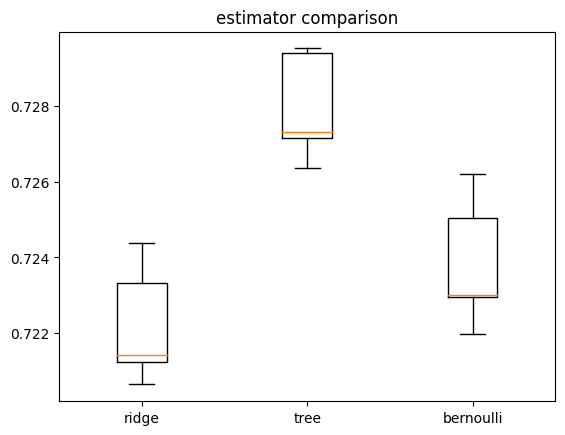

In [266]:
plt.boxplot(scores, labels=models_initial.keys())
plt.title("estimator comparison")
plt.show()

In [364]:
# determine cross-validation score for a list of models
models_tree = {
    "tree": DecisionTreeClassifier(max_depth=7, random_state=seed),
    'forest': RandomForestClassifier(max_depth=7, random_state=seed),
    'bagging': BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=7), random_state=seed)
}
scores_tree = [cross_val_score(clf, X_train, y_train, cv=kf) for clf in models_tree.values()]

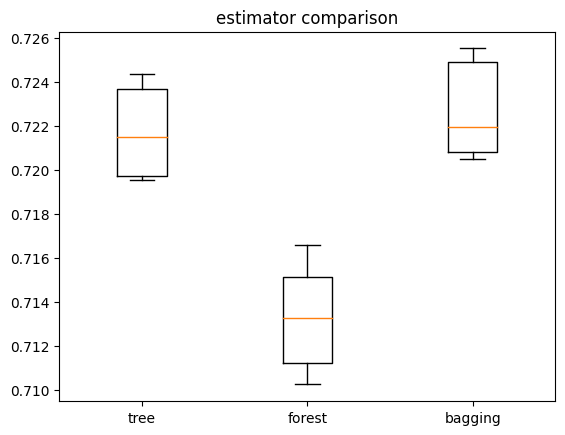

In [365]:
plt.boxplot(scores_tree, labels=models_tree.keys())
plt.title("estimator comparison")
plt.show()

### Decision Tree

In [334]:
# convert scores to a dataframe 
tree = DecisionTreeClassifier(random_state=seed)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)


In [335]:
from sklearn.metrics import ConfusionMatrixDisplay

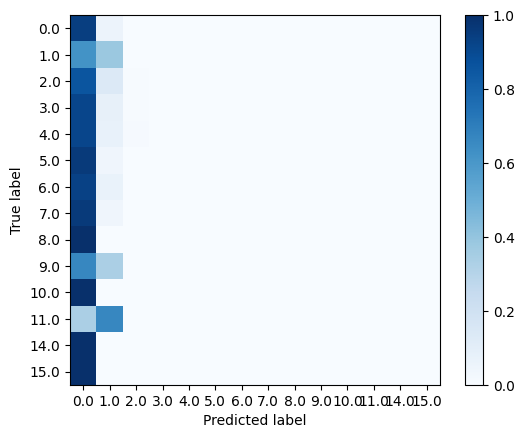

In [336]:
ConfusionMatrixDisplay.from_estimator(tree, X_test, y_test, normalize='true', include_values=False, cmap=plt.cm.Blues)

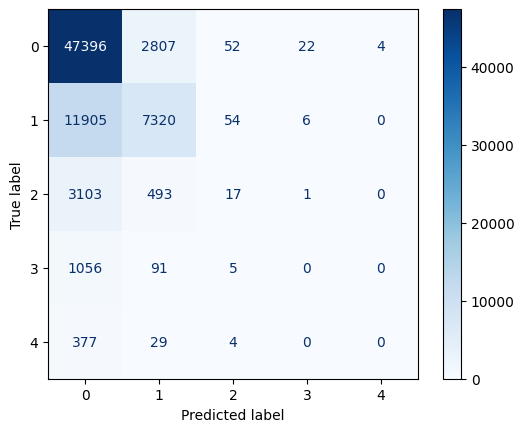

In [337]:
cm = confusion_matrix(y_test, y_pred)
cm_small = cm[0:5, 0:5]
cm_small_ratio = cm_small / cm_small.sum()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_small)
disp.plot(cmap=plt.cm.Blues)

### Boosting

In [353]:
from sklearn.ensemble import AdaBoostClassifier
dt = DecisionTreeClassifier(max_depth=2, random_state=seed)
ada = AdaBoostClassifier(estimator=dt, n_estimators=100)

In [354]:
ada_cv = cross_val_score(ada, X_train, y_train, cv=kf)

In [370]:
models_tree['ada'] = ada
scores_tree.append(ada_cv)


[array([0.72364444, 0.72148889, 0.71972711, 0.7195271 , 0.72432721]),
 array([0.71511111, 0.7112    , 0.71323807, 0.71023801, 0.7165937 ]),
 array([0.72491111, 0.72195556, 0.72081602, 0.72046045, 0.72550501]),
 array([0.70982222, 0.70573333, 0.69317096, 0.70534901, 0.71183804])]

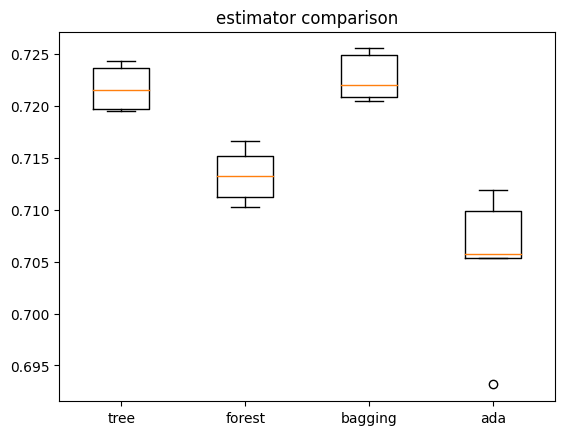

In [371]:
plt.boxplot(scores_tree, labels=models_tree.keys())
plt.title("estimator comparison")
plt.show()

### Hyper-Parameter Boosting

#### Decision Tree Classifier

In [338]:
# we first have a closer look at the Ridge Classifier
from sklearn.model_selection import GridSearchCV

In [339]:
tree_params = [
    {
        "criterion": ["gini", "entropy"], 
        "max_depth": np.arange(1, 11),
        }
    ]
tree_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), tree_params, cv=kf)
tree_cv.fit(X_train, y_train)
tree_cv_res = pd.DataFrame.from_dict(tree_cv.cv_results_)

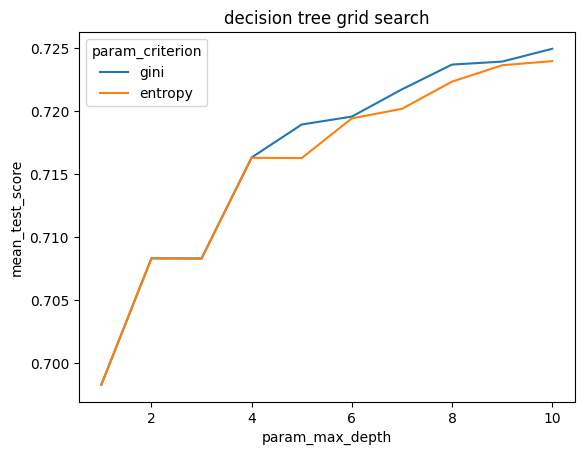

In [340]:
# sns.lineplot(data=tree_cv_res, x="param_max_depth", y = "mean_test_score", hue="param_min_samples_leaf")
# ax = sns.lineplot(data=tree_cv_res, x="param_min_samples_leaf", y = "mean_test_score", hue="param_max_depth")
ax = sns.lineplot(data=tree_cv_res, x="param_max_depth", y = "mean_test_score", hue="param_criterion")
ax.set(
    title="decision tree grid search"
)
plt.show()

#### Random Forest

In [247]:
from sklearn.ensemble import RandomForestClassifier

In [248]:
forest = RandomForestClassifier()
cross_val_score(forest, X_train, y_train, cv=kf)


array([0.7296    , 0.72795556, 0.72846063, 0.7273495 , 0.72943843])

In [202]:
tree_cv.best_estimator_

DecisionTreeClassifier(max_depth=1, random_state=42)

### Random Forest

In [66]:
# test random tree classifier
from sklearn.ensemble import RandomForestClassifier

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn-ensemble-randomforestclassifier
rf = RandomForestClassifier(
    # n_estimators=10
    )
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.9802

In [67]:
confusion_matrix(y_test, rf.predict(X_test))

array([[23524,   276,     1],
       [  198,   981,     0],
       [    7,    13,     0]], dtype=int64)

In [268]:
from sklearn.neighbors import KNeighborsClassifier

# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn-neighbors-kneighborsclassifier
clf_knn = KNeighborsClassifier(algorithm="ball_tree")
clf_knn = clf_knn.fit(X_train, y_train)
clf_knn.score(X_test, y_test)